In [1]:
from game import controlled_run

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import numpy as np
from game import DO_NOTHING
from game import JUMP

import matplotlib.pyplot as plt

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from game import controlled_run

import random
import numpy as np
from collections import deque


In [3]:
games_count = 0
total_number_of_games = 20

# flaw in game design, it should be based on whether or not you make it past an opponent
class Wrapper(object):
    
    def __init__(self,dqn_solver,games=20):
        self.dqn_solver = dqn_solver
        self.scores=[]
        self.rewards=[]
        self.epoch = 0
        self.games=games
        controlled_run(self,0)
        
    def control(self,values):
        dqn_solver = self.dqn_solver
        if(values['closest_enemy']!=-1):
            state = [[values['closest_enemy']/1000]]
            action = dqn_solver.act(state)
            self.action = action
            self.old_values= values
        else:
            action=0
        return action
    
    def reward(self,old_values,new_values,action,score,done=False):
        import Enemy
        if(old_values['closest_enemy']!= -1):
            state = [[old_values['closest_enemy']/1000]]
            next_state = [[new_values['closest_enemy']/1000]]
            if(new_values['old_closest_enemy']+25 < 380 and new_values['old_closest_enemy']+25 != 24):
                reward = 2
                print("Rewarded for Jumping Over!")
            else:
                reward = 0#new_values['score_increased']
            
            if(done==True):
                reward=-1
                previous =  list(dqn_solver.memory[len(dqn_solver.memory)-1])
                previous[0] = previous[0]
                previous[1] = previous[1]
                previous[2]= reward
                previous[3] = next_state
                previous[4] = done
                previous = tuple(previous)
                dqn_solver.memory = dqn_solver.memory[0:(len(dqn_solver.memory)-1)]
                
                dqn_solver.memory.append(previous)

                # print(previous)

                print("Round: " + str(self.epoch) + " Score: " + str(score))
                # print(dqn_solver.memory[:-min(5,len(dqn_solver.memory))])

                dqn_solver.experience_replay()
            else:
                # print(state,action,reward,next_state,done)
                # print(dqn_solver.memory[:-5])
                dqn_solver.remember(state,action,reward,next_state,done)
                dqn_solver.experience_replay()
    def get_scores(self):
        return self.scores
    
    def get_rewards(self):
        return self.rewards

    def setPlayer(self,player):
        self.player = player

    def setEnemy(self,enemy):
        self.enemy = enemy
    
    def setCurrentScore(self,score):
        self.currentScore = score

    def gameover(self,score,values):
        self.scores.append(score)
        print(self.epoch)
        self.epoch+=1
        if(self.epoch < self.games):
            return controlled_run(self,self.epoch)

In [4]:
gamma = 0.5
alpha = 0.5
learning_rate_adam = 0.05
epsilon = 0.99
epsilon_decay = 0.95
class DQN:

    def __init__(self, observation_space, action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.memory = []
        self.batch_size = 64

        #model
        # self.model = Sequential()
        # self.model.add(Dense(64, input_shape=(observation_space,), activation="elu", kernel_initializer='he_normal'))
        # self.model.add(BatchNormalization())
        # #self.model.add(Dense(64, activation="relu"))
        # #self.model.add(BatchNormalization())
        # #self.model.add(Dense(32, activation="relu"))
        # #self.model.add(Dense(16, activation="relu", kernel_initializer='he_uniform'))
        # self.model.add(Dense(128, activation="elu", kernel_initializer='he_normal'))
        # #self.model.add(BatchNormalization())
        # self.model.add(Dense(64, activation="elu", kernel_initializer='he_normal'))
        # self.model.add(Dense(32, activation="elu", kernel_initializer='he_normal'))
        # self.model.add(Dense(16, activation="elu", kernel_initializer='he_normal'))

        # #self.model.add(Dropout(0.1))
        # self.model.add(BatchNormalization())
        # self.model.add(Dense(self.action_space, activation="linear"))
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=learning_rate_adam))
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            # print("RANDOM!")
            return random.randrange(self.action_space)
        q = self.model.predict(state)
        print("Measured: " + str(q[0]), state,np.argmax(q[0]))
        return np.argmax(q[0])

    def experience_replay(self):
        # print(self.memory,self.batch_size)
        import pandas as pd
    
        # organized_memory = pd.DataFrame([list(x) for x in self.memory])
        # organized_memory.columns = ['state','action','reward','next_state','done']
        # organized_memory['reward_abs'] = [abs(x) for x in organized_memory['reward']]
        # print(organized_memory['reward_abs'])
        # mem_sample=organized_memory.sample(n=min(len(self.memory),self.batch_size), weights='reward_abs').drop('rewards_abs',axis=1).values

        mem_sample = random.sample(self.memory, min(len(self.memory),self.batch_size))

        for state, action, reward, next_state, done in mem_sample:
            # print(state, action, reward, next_state, done)
            update_value = reward
            # print(update_value)
            if not done:
                # print("Discounting")
                update_value = self.alpha * (reward + self.gamma * np.max(self.model.predict(next_state)[0]))
            q = self.model.predict(state)
            if(update_value!=0):
                q[0][action] = update_value
            # print(state,type(state))
            # print(state,next_state,action,reward,q,done)
            self.model.train_on_batch(np.array(state), q)
        self.epsilon *= epsilon_decay
        print("Epsilon: " + str(self.epsilon))

        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

In [8]:
dqn_solver = DQN(1,2)
game = Wrapper(dqn_solver,50)

/usr/local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epsilon: 0.9405
Epsilon: 0.8934749999999999
Epsilon: 0.8488012499999998
Epsilon: 0.8063611874999999
Epsilon: 0.7660431281249999
Measured: [-0.02458804 -0.07177126] [[0.205]] 0
Round: 0 Score: 2
Epsilon: 0.7277409717187499
0
Epsilon: 0.6913539231328123
Epsilon: 0.6567862269761716
Epsilon: 0.623946915627363
Epsilon: 0.5927495698459949
Measured: [-0.01414474 -0.22135983] [[0.478]] 0
Epsilon: 0.5631120913536951
Rewarded for Jumping Over!
Epsilon: 0.5349564867860104
Measured: [ 0.01825936 -0.10060547] [[1.0]] 0
Epsilon: 0.5082086624467098
Epsilon: 0.4827982293243743
Measured: [0.05285481 0.03657252] [[0.751]] 0
Epsilon: 0.45865831785815553
Measured: [-0.00126667 -0.03545507] [[0.595]] 0
Epsilon: 0.4357254019652477
Round: 1 Score: 9
Epsilon: 0.41393913186698533
1
Measured: [-0.15814734  0.05116063] [[1.0]]

In [6]:
scores = game.get_scores()

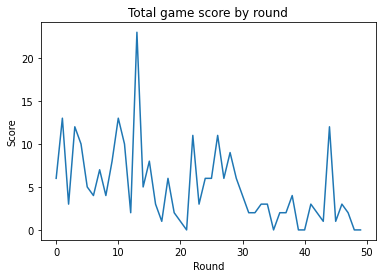

In [7]:
plt.plot(scores)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [11]:
scores_start = scores[:50]

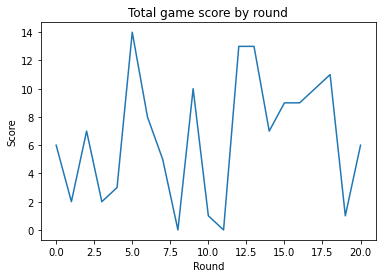

In [12]:
plt.plot(scores_start)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [12]:
rewards = np.array(game.get_rewards()).T

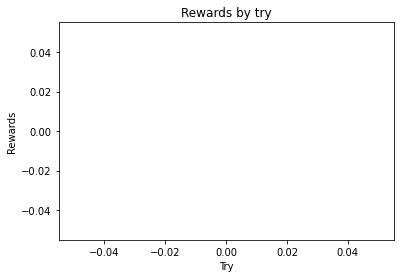

In [13]:
plt.plot(rewards)
plt.xlabel('Try')
plt.ylabel('Rewards')
plt.title('Rewards by try')
plt.show()